# **Time Series analysis - Rice Price**

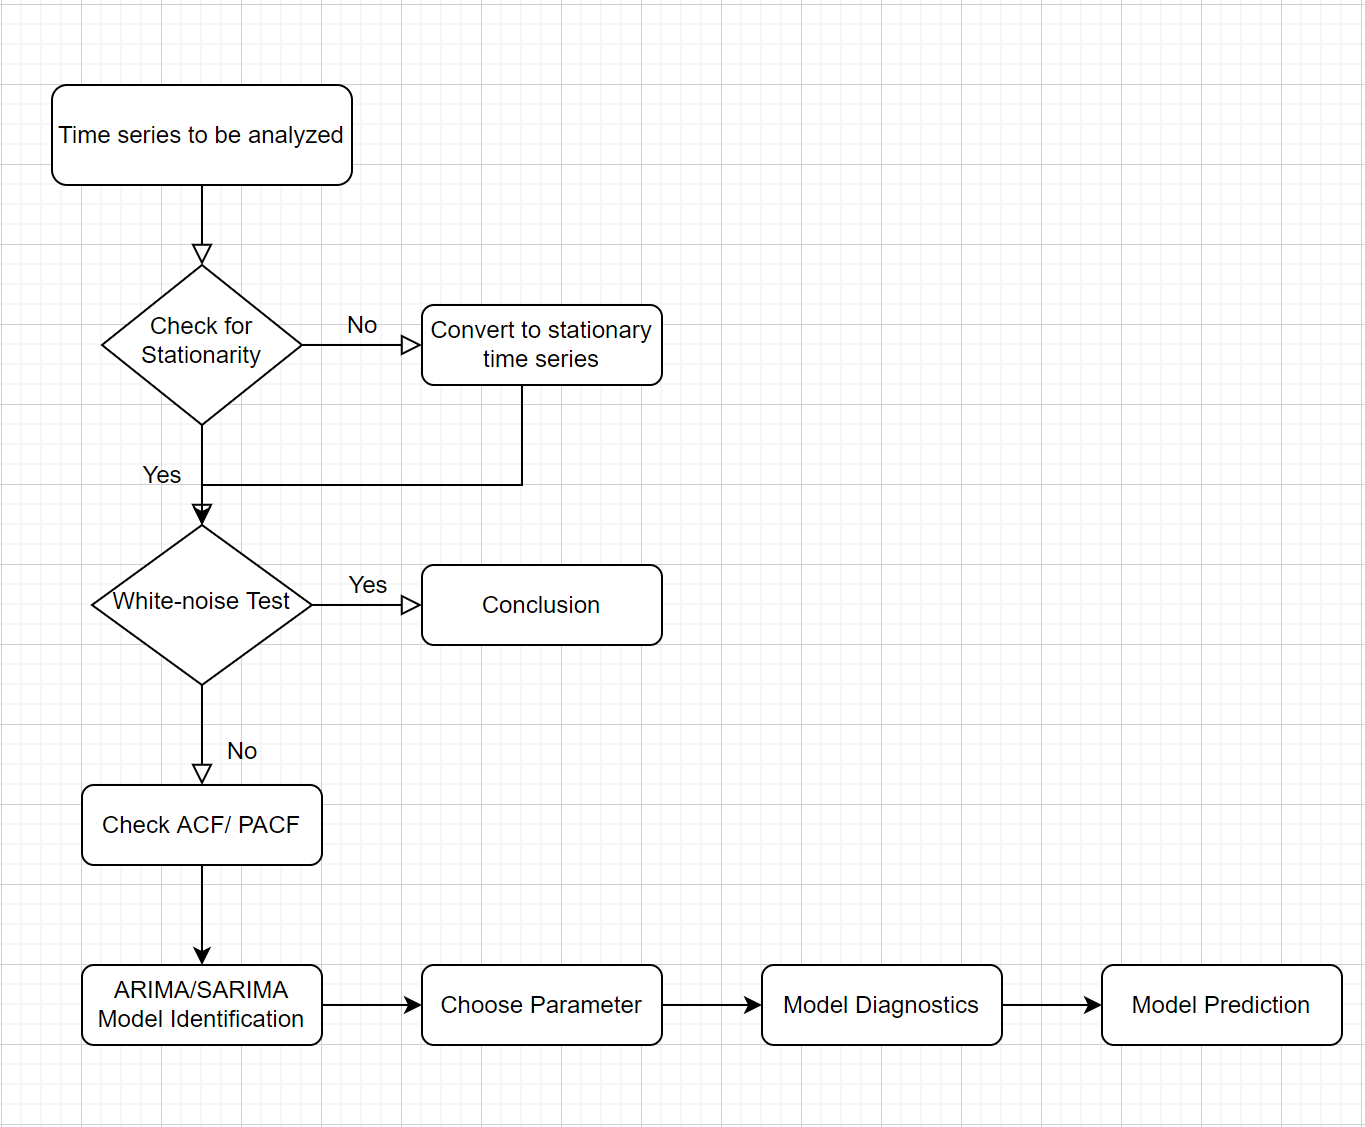

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#import warnings
#warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Load dataset**

In [2]:
#load the data
rice = pd.read_csv("../content/Rough Rice Futures Historical Data.csv")
#Dataset downloaded from https://www.investing.com/commodities/rough-rice-historical-data

In [3]:
rice['Date'] = pd.to_datetime(rice['Date'], errors='coerce')

In [4]:
rice = rice.sort_values(by="Date")
rice

,Date,Price,Open,High,Low,Vol.,Change %
2776,2011-01-03,14.185,14.030,14.340,14.025,0.09K,1.36%
2775,2011-01-04,13.885,14.190,14.245,13.865,0.25K,-2.11%
2774,2011-01-05,13.825,13.695,13.695,13.695,0.01K,-0.43%
2773,2011-01-06,13.655,13.930,0.000,13.690,0.05K,-1.23%
2772,2011-01-07,13.390,13.380,13.380,13.380,0.01K,-1.94%
...,...,...,...,...,...,...,...
4,2021-12-27,14.340,14.010,14.340,13.990,0.47K,1.49%
3,2021-12-28,14.465,14.270,14.525,14.240,0.42K,0.87%
2,2021-12-29,14.550,14.450,14.620,14.450,0.25K,0.59%
1,2021-12-30,14.575,14.580,14.625,14.470,0.34K,0.17%


**First insight into data**

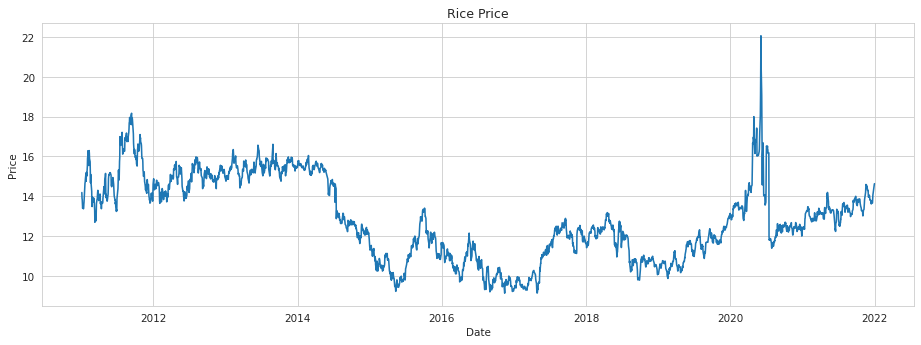

In [35]:
#have a first insight into the development of Rice Price
plt.figure(figsize=(15,5))
sns.lineplot(data=rice, x="Date", y="Price")
plt.title("Rice Price"); plt.savefig('TS_Original_Rice_Price.png')

In [6]:
rice = rice[["Date","Price"]]
rice

,Date,Price
2776,2011-01-03,14.185
2775,2011-01-04,13.885
2774,2011-01-05,13.825
2773,2011-01-06,13.655
2772,2011-01-07,13.390
...,...,...
4,2021-12-27,14.340
3,2021-12-28,14.465
2,2021-12-29,14.550
1,2021-12-30,14.575


In [7]:
rice_copy = rice.copy()
rice_copy.set_index('Date', inplace=True)

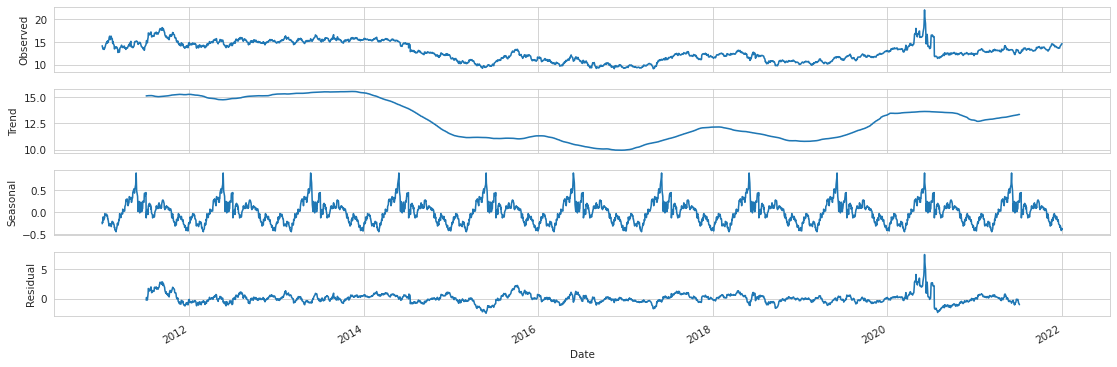

In [36]:
#decomposes the time series into trend, seasonal and irregular components
plt.rcParams.update({'figure.figsize':(15,5), 'figure.dpi':75})
result = seasonal_decompose(rice_copy, model='additive',freq=253)
result.plot(); plt.savefig('TS_Rice_Price_seasonal_decompose.png')

**Checks for Stationarity - Augmented Dickey-Fuller test**

In [9]:
#check whether the original time series is stationary
result = adfuller(rice["Price"])

In [10]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.595298
p-value: 0.093973
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [11]:
#The time series is stationary at 10% sig. level, not at 1% and 5%.

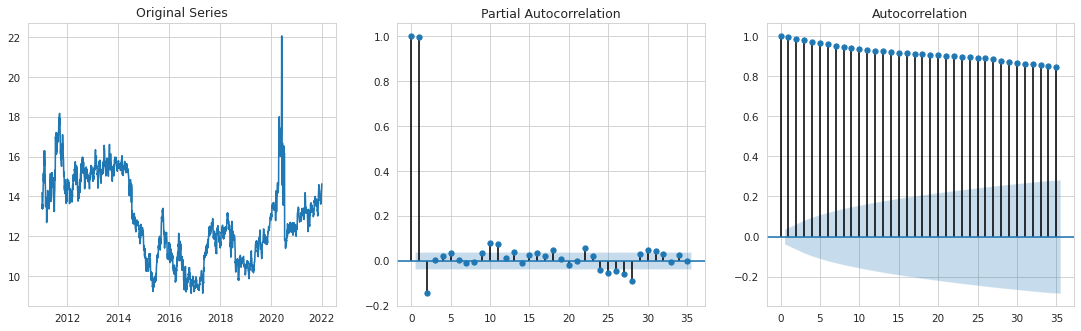

<Figure size 1350x375 with 0 Axes>

In [37]:
plt.rcParams.update({'figure.figsize':(18,5), 'figure.dpi':75})

# Original Series
fig, axes = plt.subplots(1, 3)
axes[0].plot(rice_copy); axes[0].set_title('Original Series')
plot_pacf(rice_copy, ax=axes[1])
plot_acf(rice_copy, ax=axes[2])
plt.show(); plt.savefig('TS_Original_PACF_ACF')

In [13]:
#rice_copy.diff().plot()

In [14]:
# to get stationary time series, try to take a first difference of the time series
rice_diff = rice_copy.diff()[1:]

In [15]:
result = adfuller(rice_diff["Price"])

In [16]:
#check whether the first difference of original time series is stationary
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.211687
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [17]:
#The first difference of original time series is stationary

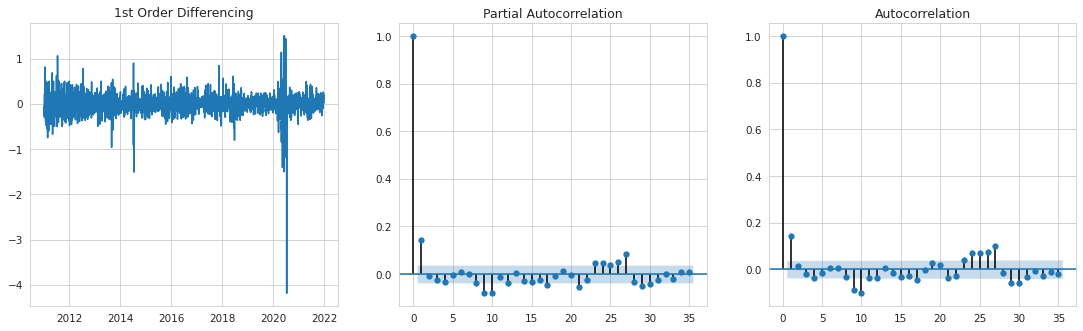

<Figure size 1350x375 with 0 Axes>

In [38]:
plt.rcParams.update({'figure.figsize':(18,5), 'figure.dpi':75})

# 1st Differencing
fig, axes = plt.subplots(1, 3)
axes[0].plot(rice_copy.diff()); axes[0].set_title('1st Order Differencing')
plot_pacf(rice_copy.diff().dropna(), ax=axes[1])
plot_acf(rice_copy.diff().dropna(), ax=axes[2])
plt.show(); plt.savefig('TS_1stOrderDifferencing_PACF_ACF')

In [19]:
#The first difference of original time series seems to be also autocorrelated, not white noise. 

**Build Models**

In [20]:
#build ARIMA model
#from the plot above, a good guess for the parameter of (p,d,q) would be (1,1,1).
model_rice = ARIMA(rice_copy, order = (1, 1, 1))
rice_111 = model_rice.fit(disp=0)
print(rice_111.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 2776
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 303.466
Method:                       css-mle   S.D. of innovations              0.217
Date:                Mon, 21 Feb 2022   AIC                           -598.933
Time:                        19:14:10   BIC                           -575.218
Sample:                             1   HQIC                          -590.369
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.005      0.031      0.976      -0.009       0.009
ar.L1.D.Price     0.1042      0.118      0.881      0.378      -0.128       0.336
ma.L1.D.Price     0.0375      0.118     

In [21]:
#But still try some other parameters of (p,d,q) for the ARIMA model.
model_rice = ARIMA(rice_copy, order = (1, 1, 0))
rice_111 = model_rice.fit(disp=0)
print(rice_111.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 2776
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 303.416
Method:                       css-mle   S.D. of innovations              0.217
Date:                Mon, 21 Feb 2022   AIC                           -600.831
Time:                        19:14:10   BIC                           -583.045
Sample:                             1   HQIC                          -594.408
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.005      0.030      0.976      -0.009       0.010
ar.L1.D.Price     0.1409      0.019      7.498      0.000       0.104       0.178
                                    Root

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [22]:
model_rice = ARIMA(rice_copy, order = (2, 1, 2))
rice_111 = model_rice.fit(disp=0)
print(rice_111.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 2776
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 305.899
Method:                       css-mle   S.D. of innovations              0.217
Date:                Mon, 21 Feb 2022   AIC                           -599.797
Time:                        19:14:12   BIC                           -564.225
Sample:                             1   HQIC                          -586.951
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.004      0.036      0.971      -0.008       0.009
ar.L1.D.Price     0.8636      0.179      4.838      0.000       0.514       1.214
ar.L2.D.Price    -0.6952      0.251     

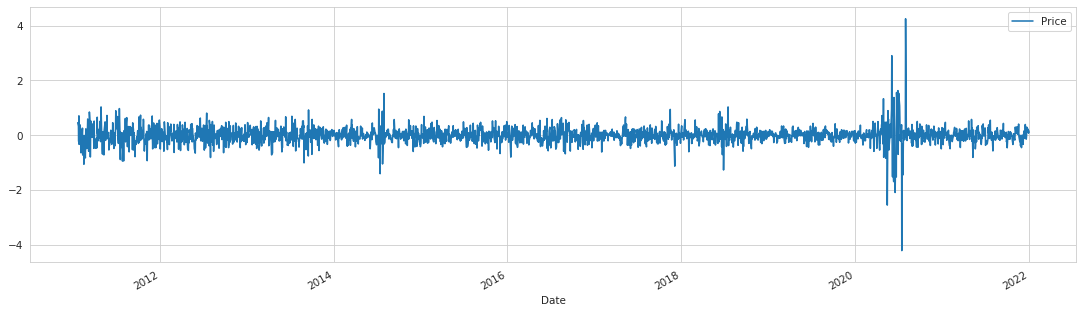

In [39]:
ts_s_adj = rice_copy.diff() - rice_copy.diff().shift(12)
ts_s_adj = ts_s_adj.dropna()
ts_s_adj.plot(); plt.savefig('TS_ts_s_adj')

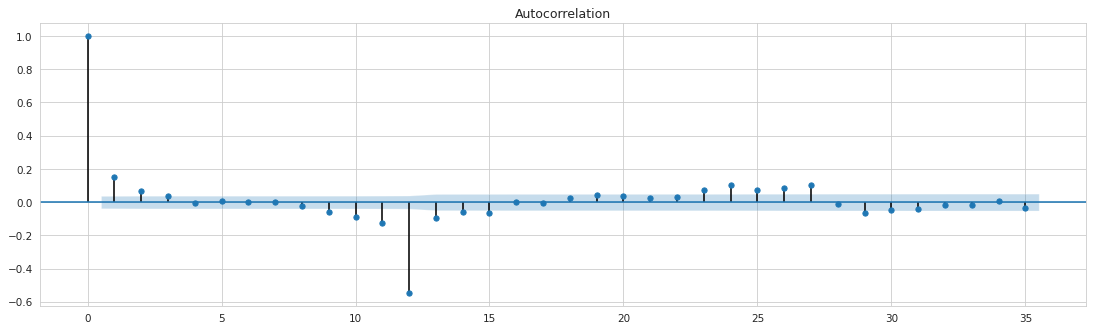

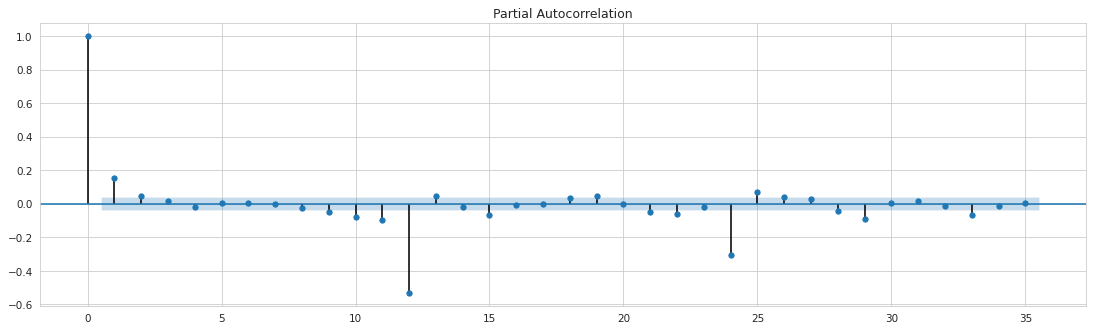

In [40]:
# Plot ACF and PACF charts for the seasonal first difference values, find the optimal parameters for SARIMA model.
plot_acf(ts_s_adj); plt.savefig('TS_ts_s_adj_PACF')
plot_pacf(ts_s_adj); plt.savefig('TS_ts_s_adj_ACF')

In [46]:
#the autocorrelation of the differenced series is negative at lag 12 (one year later).
mod = sm.tsa.statespace.SARIMAX(rice_copy, trend='n', order=(1,1,1), seasonal_order=(1,0,1,12))
result = mod.fit()
result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 2777
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 307.866
Date:                            Mon, 21 Feb 2022   AIC                           -605.731
Time:                                    19:32:05   BIC                           -576.088
Sample:                                         0   HQIC                          -595.026
                                           - 2777                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0731      0.066      1.109      0.267      -0.056       0.202
ma.L1          0.0653      0.070      0.930      0.353      -0.072       0.203
ar.S.L12      -0.6172      0.218     -2.829      0.005      -1.045      -0.190
ma.S.L12       0.5726      0.226      2.538      0.011       0.130       1.015
sigma2         0.0469      0.000    163.116      0.000       0.046       0.047
===================================================================================
Ljung-Box (Q):                      137.42   Jarque-Bera (JB):            377033.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -2.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        59.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
#try different parameters for SARIMA model
mod2 = sm.tsa.statespace.SARIMAX(rice_copy, trend='n', order=(2,1,2), seasonal_order=(2,1,2,12))
result2 = mod2.fit()
result2.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 2777
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                 285.270
Date:                            Mon, 21 Feb 2022   AIC                           -552.540
Time:                                    19:16:26   BIC                           -499.220
Sample:                                         0   HQIC                          -533.281
                                           - 2777                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2347      0.058     21.438      0.000       1.122       1.348
ar.L2         -0.3029      0.057     -5.359      0.000      -0.414      -0.192
ma.L1         -1.1077      0.064    -17.353      0.000      -1.233      -0.983
ma.L2          0.1552      0.062      2.485      0.013       0.033       0.278
ar.S.L12      -0.4166      0.271     -1.536      0.125      -0.948       0.115
ar.S.L24       0.0444      0.017      2.609      0.009       0.011       0.078
ma.S.L12      -0.5921      0.272     -2.176      0.030      -1.125      -0.059
ma.S.L24      -0.3960      0.270     -1.466      0.143      -0.925       0.133
sigma2         0.0467      0.000    113.371      0.000       0.046       0.048
===================================================================================
Ljung-Box (Q):                      110.24   Jarque-Bera (JB):            349744.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -2.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
#based on AIC, SARIMA (1,1,1)x(1,0,1,12) will be choosed.  

**Model diagnostics**

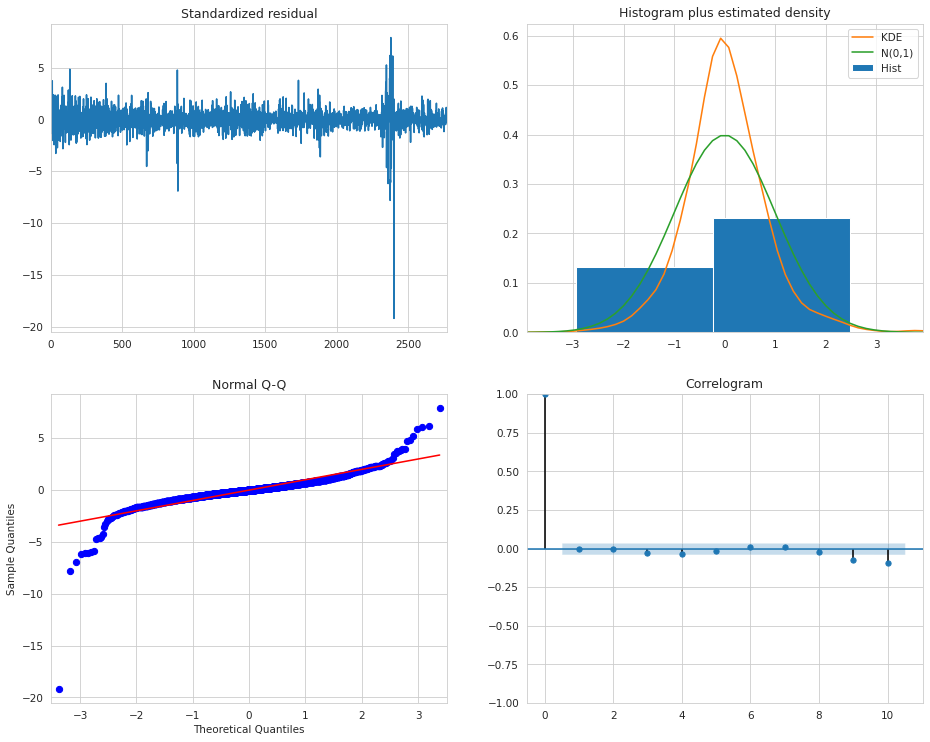

In [49]:
#to ensure that the residuals of the model is uncorrelated and normally distributed with zero-mean
result.plot_diagnostics(figsize=(15,12)); plt.savefig('TS_Model_Diagnostics.png')

In [29]:
#The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows quite well the linear trend of the samples taken from a standard normal distribution with N(0, 1).
#The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise.

**Make Prediction**

In [30]:
#Forecast
pred = result.get_prediction(start=pd.to_datetime('2021-01-04'), dynamic=False)
pred_ci = pred.conf_int()

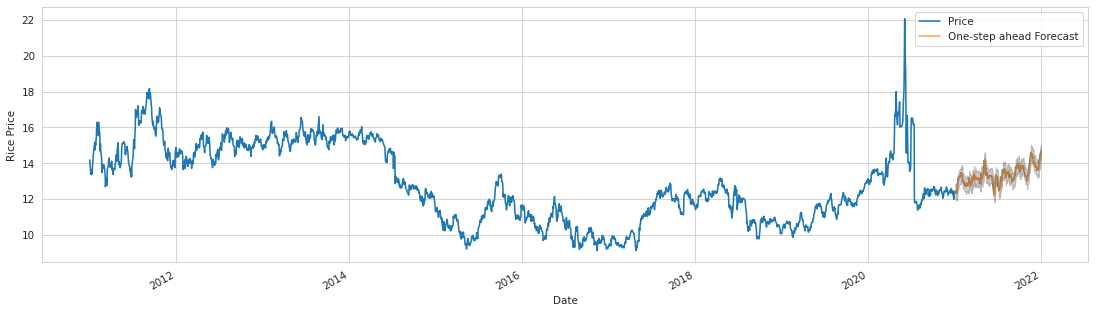

<Figure size 1350x375 with 0 Axes>

In [48]:
ax = rice_copy['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Rice Price')
plt.legend()

plt.show(); plt.savefig('TS_Rice_Price_Prediction')

In [32]:
y_forecasted = pred.predicted_mean
y_truth = rice_copy['2021-01-04':]

# accuracy of forecasts, compute the mean square error
#mse = ((y_forecasted - y_truth) ** 2).mean()
mse = ((y_forecasted - pd.Series(y_truth["Price"])) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.02
